In [ ]:
import torch

# Check pytorch version and make sure you use a GPU Kernel
!python -c "import torch; print(torch.__version__)"
!python -c "import torch; print(torch.version.cuda)"
!nvidia-smi

Воспользуемся еще старой версией pytorch geometric, в Colab иногда возникали проблемы с новыми версиями.

In [ ]:
%%bash
TORCH="1.10.0"
CUDA="cu111"
pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}+${CUDA}.html
pip install torch-geometric

In [ ]:
!pip install decorator numpy matplotlib tqdm networkx ninja jinja2 rdkit-pypi

# Упражнение 1

Будем использовать датасет KarateClub. Этот график описывает социальную сеть из 34 членов клуба карате и документирует связи между участниками, которые взаимодействовали вне клуба. Здесь мы заинтересованы в обнаружении сообществ, возникающих в результате взаимодействия участников.

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx


def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                     node_color=color, cmap="Set2")
    plt.show()


def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    plt.show()

In [ ]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

In [ ]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh()  # Final GNN embedding space.

        # Apply a final (linear) classifier.
        out = self.classifier(h)

        return out, h

model = GCN()
print(model)

In [ ]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize_embedding(h, color=data.y)

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize_embedding(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)

На картинках показывалось как  эволюционируют эмбеддинги с течением времени

# Упражнение 2

Будем использовать датасет eSOL - данные о растворимости всех белков E.coli. Наша графовая нейронная сеть (GNN) будет предсказывать растворимость белков.

In [ ]:
import rdkit
from torch_geometric.datasets import MoleculeNet

# Load the ESOL dataset
data = MoleculeNet(root=".", name="ESOL")
data

Посмотрим на конструкцию датасета:


1.   тип
2.   количество фичей
3.   количество классов
4.   длина
5.   количество нод в выборке
6.   количество ребер в выборке





In [ ]:
print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)

In [ ]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
molecule = Chem.MolFromSmiles(data[0]["smiles"])
molecule

Теперь нарисуем с 5 по 10 молекулы датасета с попомщью [rdkit.Chem.Draw](https://www.rdkit.org/docs/source/rdkit.Chem.Draw.html) и команды display

In [ ]:
for i in data#PUT YOUR CODE HERE
    molecule = Chem.MolFromSmiles(i["smiles"])
    display(molecule)

Архитектура GNN

Добавьте функции активации

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
embedding_size = 64

class GCN(torch.nn.Module):
    def __init__(self):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers
        self.initial_conv = GCNConv(data.num_features, embedding_size)
        self.conv1 = GCNConv(embedding_size, embedding_size)
        self.conv2 = GCNConv(embedding_size, embedding_size)
        self.conv3 = GCNConv(embedding_size, embedding_size)

        # Output layer
        self.out = Linear(embedding_size * 2, data.num_classes)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.relu(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = #PUT YOUR CODE HERE
        hidden = self.conv2(hidden, edge_index)
        hidden = #PUT YOUR CODE HERE
        hidden = self.conv3(hidden, edge_index)
        hidden = #PUT YOUR CODE HERE

        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index),
                            gap(hidden, batch_index)], dim=1)

        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

model = GCN()
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

Обучим нейросеть

In [ ]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Use GPU for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 64
loader = DataLoader(data[:int(data_size * 0.8)],
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(data[int(data_size * 0.8):],
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)

def train(data):
    # Enumerate over the data
    for batch in loader:
      # Use GPU
      batch.to(device)
      # Reset gradients
      optimizer.zero_grad()
      # Passing the node features and the connection info
      pred, embedding = model(batch.x.float(), batch.edge_index, batch.batch)
      # Calculating the loss and gradients
      loss = torch.sqrt(loss_fn(pred, batch.y))
      loss.backward()
      # Update using the gradients
      optimizer.step()
    return loss, embedding

print("Starting training...")
losses = []
for epoch in range(2000):
    loss, h = train(data)
    losses.append(loss)
    if epoch % 100 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Визуализируем лосс

In [ ]:
import seaborn as sns

losses_float = [float(loss.cpu().detach().numpy()) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt = sns.lineplot(loss_indices, losses_float)
plt

Проанализируем результаты для одного батча

In [ ]:
import pandas as pd

test_batch = next(iter(test_loader))
with torch.no_grad():
    test_batch.to(device)
    pred, embed = model(test_batch.x.float(), test_batch.edge_index, test_batch.batch)
    df = pd.DataFrame()
    df["y_real"] = test_batch.y.tolist()
    df["y_pred"] = pred.tolist()
df["y_real"] = df["y_real"].apply(lambda row: row[0])
df["y_pred"] = df["y_pred"].apply(lambda row: row[0])

plt = sns.scatterplot(data=df, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))
plt

По одной оси реальные y, по другой предсказания неросети. Если предсказанные y идеально соответствуют реальным, то на графике должна быть одна диагональная линия без каких-либо выбросов в стороны

Что еще можно добавить в нейросеть, чтобы улучшить ее качество?

#Упражнение 3

В этом упражнении будем использовать другой датасет. Mutagenicity - это данные о химическом составе лекарств, который можно разделить на два класса: мутагены и немутагены. Таким образом здесь GNN будет предсказывать мутагенность молекулы

In [ ]:
from torch_geometric.datasets import TUDataset

# Atom types, ordered accroding to one-hot-encoding
MUT_LABEL_ENC = pd.Series(data = ["C","O", "Cl","H","N","F","Br","S","P","I","Na","K","Li","Ca"])
print("Number of different elements: ", len(MUT_LABEL_ENC))

# Define transform
class AddSymbols(object):
    """
    Add the symbol of the elements, from the atomic number, as a key of the graph
    """
    def __call__(self, graph):
        graph.symbols = MUT_LABEL_ENC.loc[graph.x.argmax(dim=-1)].values

        return graph

# Load the dataset
dataset = TUDataset(
    root=".", name="Mutagenicity",
    transform=AddSymbols(),
).shuffle()

In [ ]:
import numpy as np

print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Samples per class: {[ np.sum([1 for graph in dataset if graph.y == i ]) for i in range(dataset.num_classes) ]}')

all_atoms = np.concatenate(
    [graph.symbols for graph in dataset]
)
print(f"{len(np.unique(all_atoms))} unique atoms: {np.unique(all_atoms)}")

##Упражнение 3.1

[NetworkX](https://github.com/networkx/networkx) - это библиотека для работы с графами. С ее помощью можно строить красивые графы. Давайте посмотрим на несколько примеров

Направленный граф

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx

seed = 13648  # Seed random number generators for reproducibility
G = nx.random_k_out_graph(10, 3, 0.5, seed=seed)
pos = nx.spring_layout(G, seed=seed)

node_sizes = [3 + 10 * i for i in range(len(G))]
M = G.number_of_edges()
edge_colors = range(2, M + 2)
edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
cmap = plt.cm.plasma

nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="indigo")
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="->",
    arrowsize=10,
    edge_color=edge_colors,
    edge_cmap=cmap,
    width=2,
)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=cmap)
pc.set_array(edge_colors)
plt.colorbar(pc)

ax = plt.gca()
ax.set_axis_off()
plt.show()

Случайный геометрический граф

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Use seed when creating the graph for reproducibility
G = nx.random_geometric_graph(200, 0.125, seed=896803)
# position is stored as node attribute data for random_geometric_graph
pos = nx.get_node_attributes(G, "pos")

# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x - 0.5) ** 2 + (y - 0.5) ** 2
    if d < dmin:
        ncenter = n
        dmin = d

# color by path length from node near center
p = dict(nx.single_source_shortest_path_length(G, ncenter))

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=list(p.keys()),
    node_size=80,
    node_color=list(p.values()),
    cmap=plt.cm.Reds_r,
)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.show()

Радужный граф с нумерацией вершин

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# A rainbow color mapping using matplotlib's tableau colors
node_dist_to_color = {
    1: "tab:red",
    2: "tab:orange",
    3: "tab:olive",
    4: "tab:green",
    5: "tab:blue",
    6: "tab:purple",
}

# Create a complete graph with an odd number of nodes
nnodes = 13
G = nx.complete_graph(nnodes)

# A graph with (2n + 1) nodes requires n colors for the edges
n = (nnodes - 1) // 2
ndist_iter = list(range(1, n + 1))

# Take advantage of circular symmetry in determining node distances
ndist_iter += ndist_iter[::-1]


def cycle(nlist, n):
    return nlist[-n:] + nlist[:-n]


# Rotate nodes around the circle and assign colors for each edge based on
# node distance
nodes = list(G.nodes())
for i, nd in enumerate(ndist_iter):
    for u, v in zip(nodes, cycle(nodes, i + 1)):
        G[u][v]["color"] = node_dist_to_color[nd]

pos = nx.circular_layout(G)
# Create a figure with 1:1 aspect ratio to preserve the circle.
fig, ax = plt.subplots(figsize=(8, 8))
node_opts = {"node_size": 500, "node_color": "w", "edgecolors": "k", "linewidths": 2.0}
nx.draw_networkx_nodes(G, pos, **node_opts)
nx.draw_networkx_labels(G, pos, font_size=14)
# Extract color from edge data
edge_colors = [edgedata["color"] for _, _, edgedata in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, width=2.0, edge_color=edge_colors)

ax.set_axis_off()
fig.tight_layout()
plt.show()

Граф с цветовой схемой по вершинам

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

G = nx.cycle_graph(24)
pos = nx.circular_layout(G)
nx.draw(G, pos, node_color=range(24), node_size=800, cmap=plt.cm.Blues)
plt.show()

3D граф

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# The graph to visualize
G = nx.cycle_graph(20)

# 3d spring layout
pos = nx.spring_layout(G, dim=3, seed=779)
# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(G)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in G.edges()])

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=100, ec="w")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="tab:gray")


def _format_axes(ax):
    """Visualization options for the 3D axes."""
    # Turn gridlines off
    ax.grid(False)
    # Suppress tick labels
    for dim in (ax.xaxis, ax.yaxis, ax.zaxis):
        dim.set_ticks([])
    # Set axes labels
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")


_format_axes(ax)
fig.tight_layout()
plt.show()

Примеры с использованием дополнительной библиотеки [pygraphviz](https://pygraphviz.github.io/)

In [ ]:
!sudo apt-get install graphviz graphviz-dev
!pip install pygraphviz

In [ ]:
import math

import matplotlib.pyplot as plt
import networkx as nx

n = 150  # 150 nodes
# p value at which giant component (of size log(n) nodes) is expected
p_giant = 1.0 / (n - 1)
# p value at which graph is expected to become completely connected
p_conn = math.log(n) / n

# the following range of p values should be close to the threshold
pvals = [0.003, 0.006, 0.008, 0.015]

fig, axes = plt.subplots(2, 2)
for p, ax, seed in zip(pvals, axes.ravel(), range(len(pvals))):
    #### generate graph ####
    G = nx.binomial_graph(n, p, seed=seed)
    # identify connected/disconnected nodes
    connected = [n for n, d in G.degree() if d > 0]
    disconnected = list(set(G.nodes()) - set(connected))
    # identify largest connected component
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    G0 = G.subgraph(Gcc[0])
    #### draw graph ####
    pos = nx.nx_agraph.graphviz_layout(G)
    ax.set_title(f"p = {p:.3f}")
    # draw largest connected component
    options = {"ax": ax, "edge_color": "tab:red"}
    nx.draw_networkx_edges(G0, pos, width=6.0, **options)
    # draw other connected components
    for Gi in Gcc[1:]:
        if len(Gi) > 1:
            nx.draw_networkx_edges(
                G.subgraph(Gi),
                pos,
                alpha=0.3,
                width=5.0,
                **options,
            )
    # draw connected/disconnected nodes
    options = {"ax": ax, "node_size": 30, "edgecolors": "white"}
    nx.draw(G, pos, nodelist=connected, **options)
    nx.draw(G, pos, nodelist=disconnected, alpha=0.25, **options)
fig.tight_layout()
plt.show()

In [ ]:
import random

import matplotlib.pyplot as plt
import networkx as nx


GraphMatcher = nx.isomorphism.vf2userfunc.GraphMatcher


def atlas6():
    """Return the atlas of all connected graphs with at most 6 nodes"""

    Atlas = nx.graph_atlas_g()[3:209]  # 0, 1, 2 => no edges. 208 is last 6 node graph
    U = nx.Graph()  # graph for union of all graphs in atlas
    for G in Atlas:
        # check if connected
        if nx.number_connected_components(G) == 1:
            # check if isomorphic to a previous graph
            if not GraphMatcher(U, G).subgraph_is_isomorphic():
                U = nx.disjoint_union(U, G)
    return U


G = atlas6()

print(G)
print(nx.number_connected_components(G), "connected components")

plt.figure(1, figsize=(8, 8))
# layout graphs with positions using graphviz neato
pos = nx.nx_agraph.graphviz_layout(G, prog="neato")
# color nodes the same in each connected subgraph
C = (G.subgraph(c) for c in nx.connected_components(G))
for g in C:
    c = [random.random()] * nx.number_of_nodes(g)  # random color...
    nx.draw(g, pos, node_size=40, node_color=c, vmin=0.0, vmax=1.0, with_labels=False)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

B = nx.DiGraph()
B.add_nodes_from(["A", "B", "C", "D", "E", "F"])
B.add_edges_from(
    [("A", "B"), ("A", "C"), ("B", "D"), ("B", "F"), ("C", "E"), ("E", "F")]
)

options = {"with_labels": True, "node_color": "white", "edgecolors": "blue"}

fig = plt.figure(figsize=(6, 9))
axgrid = fig.add_gridspec(3, 2)

ax1 = fig.add_subplot(axgrid[0, 0])
ax1.set_title("Bayesian Network")
pos = nx.nx_agraph.graphviz_layout(B, prog="neato")
nx.draw_networkx(B, pos=pos, **options)

mg = nx.moral_graph(B)
ax2 = fig.add_subplot(axgrid[0, 1], sharex=ax1, sharey=ax1)
ax2.set_title("Moralized Graph")
nx.draw_networkx(mg, pos=pos, **options)

jt = nx.junction_tree(B)
ax3 = fig.add_subplot(axgrid[1:, :])
ax3.set_title("Junction Tree")
ax3.margins(0.15, 0.25)
nsize = [2000 * len(n) for n in list(jt.nodes())]
pos = nx.nx_agraph.graphviz_layout(jt, prog="neato")
nx.draw_networkx(jt, pos=pos, node_size=nsize, **options)

plt.tight_layout()
plt.show()

In [ ]:
import networkx as nx
from torch_geometric.utils import to_networkx

G = dataset[0]  # Get the first graph object.
print(G)
# Gather some statistics about the first graph.
print(f'Number of nodes: {G.num_nodes}')
print(f'Number of edges: {G.num_edges}')
print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
print(f'Contains isolated nodes: {G.has_isolated_nodes()}')
print(f'Contains self-loops: {G.has_self_loops()}')
print(f'Is undirected: {G.is_undirected()}')

G = to_networkx(G, to_undirected=True)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos)

##Упражнение 3.2

Построим граф для третьего объекта датасета

In [ ]:
G = dataset[#PUT YOUR CODE HERE]
G = to_networkx(G, to_undirected=True)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos)

In [ ]:
from torch.nn import Linear, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_add_pool

class GNN(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        hidden_dim,
        node_features_dim,
        edge_features_dim=None
    ):
        super(GNN, self).__init__()
        self.hidden_dim = hidden_dim

        self.conv1 = GraphConv(node_features_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)
        self.conv4 = GraphConv(hidden_dim, hidden_dim)
        self.conv5 = GraphConv(hidden_dim, hidden_dim)

        self.fc1 = Linear(hidden_dim, hidden_dim)
        self.fc2 = Linear(hidden_dim, num_classes)

        self.readout = LogSoftmax(dim=-1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        return self.readout(x)

In [ ]:
from torch_geometric.loader import DataLoader
from tqdm.auto import tqdm

# If possible, we use a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

idx_train_end = int(len(dataset) * .5)
idx_valid_end =  int(len(dataset) * .7)

BATCH_SIZE = 128
BATCH_SIZE_TEST = len(dataset) - idx_valid_end

# In the test loader we set the natch size to be equal to the size of the whole test set
loader_train = DataLoader(dataset[:idx_train_end], batch_size=BATCH_SIZE, shuffle=True)
loader_valid = DataLoader(dataset[idx_train_end:idx_valid_end], batch_size=BATCH_SIZE, shuffle=True)
loader_test = DataLoader(dataset[idx_valid_end:], batch_size=BATCH_SIZE_TEST, shuffle=False)

Using device: cuda


In [ ]:
from torch.nn import NLLLoss

# Model
model = GNN(
    num_classes = 2,
    hidden_dim=64,
    node_features_dim=dataset.num_node_features,
).to(device)

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters())

# Loss function
loss_function = NLLLoss()

In [ ]:
def train_model(loader_train, loader_valid, model, optimizer, loss_function, N_EPOCHS):
  # Prepare empy lists for logging
  train_losses = []

  for epoch in tqdm(range(N_EPOCHS)):
      epoch_loss = 0
      for batch in tqdm(loader_train, leave=False):
          batch.to(device)

          out = model(batch.x, batch.edge_index, batch.batch)
          loss = loss_function(out, batch.y.flatten())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          with torch.no_grad():
            train_losses.append(loss.item())

      print(f"Epoch: {epoch}, Loss: {loss}")

  return train_losses

In [ ]:
N_EPOCHS = 100
train_losses = train_model(loader_train, loader_valid, model, optimizer, loss_function, N_EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 0, Loss: 0.6233139038085938


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.6605966687202454


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.5672959685325623


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.5844947695732117


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.5733670592308044


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.5846928954124451


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.649918794631958


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.5491911768913269


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.5078527927398682


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.5235942006111145


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 10, Loss: 0.5835484266281128


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 11, Loss: 0.5139143466949463


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 12, Loss: 0.5594518780708313


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 13, Loss: 0.47463712096214294


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 14, Loss: 0.48717647790908813


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 15, Loss: 0.47683951258659363


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 16, Loss: 0.3986772298812866


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 17, Loss: 0.5140535235404968


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 18, Loss: 0.5149908661842346


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 19, Loss: 0.43108341097831726


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 20, Loss: 0.5803938508033752


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 21, Loss: 0.5200819969177246


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 22, Loss: 0.47041207551956177


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 23, Loss: 0.4294288456439972


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 24, Loss: 0.4647229015827179


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 25, Loss: 0.4158729910850525


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 26, Loss: 0.4189867079257965


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 27, Loss: 0.4119485914707184


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 28, Loss: 0.32917681336402893


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 29, Loss: 0.45233216881752014


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 30, Loss: 0.3916305899620056


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 31, Loss: 0.3939131796360016


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 32, Loss: 0.4528905749320984


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 33, Loss: 0.3888998329639435


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 34, Loss: 0.3624829649925232


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 35, Loss: 0.29329460859298706


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 36, Loss: 0.43295249342918396


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 37, Loss: 0.4259808361530304


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 38, Loss: 0.37275785207748413


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 39, Loss: 0.37217384576797485


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 40, Loss: 0.410004585981369


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 41, Loss: 0.35983699560165405


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 42, Loss: 0.3507227897644043


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 43, Loss: 0.42635783553123474


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.4030693769454956


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.36250507831573486


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 46, Loss: 0.3092835545539856


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.39470240473747253


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.30123573541641235


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 49, Loss: 0.4299827218055725


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 50, Loss: 0.34168246388435364


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 51, Loss: 0.29509714245796204


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 52, Loss: 0.2867601811885834


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 53, Loss: 0.3495250940322876


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 54, Loss: 0.37115949392318726


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 55, Loss: 0.2748125493526459


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 56, Loss: 0.2656061053276062


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 57, Loss: 0.26788702607154846


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 58, Loss: 0.33558595180511475


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 59, Loss: 0.2648886442184448


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 60, Loss: 0.3066267967224121


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 61, Loss: 0.2420836240053177


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 62, Loss: 0.44918128848075867


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 63, Loss: 0.1834215223789215


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 64, Loss: 0.28143078088760376


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 65, Loss: 0.25422778725624084


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 66, Loss: 0.2658381760120392


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 67, Loss: 0.27664914727211


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 68, Loss: 0.18700410425662994


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 69, Loss: 0.25960153341293335


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 70, Loss: 0.2537892758846283


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 71, Loss: 0.23927593231201172


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 72, Loss: 0.21516284346580505


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 73, Loss: 0.31412699818611145


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 74, Loss: 0.28685224056243896


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 75, Loss: 0.28852829337120056


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 76, Loss: 0.339500367641449


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 77, Loss: 0.30104711651802063


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 78, Loss: 0.1921948343515396


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 79, Loss: 0.2209922969341278


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 80, Loss: 0.22317738831043243


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 81, Loss: 0.21929411590099335


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 82, Loss: 0.234098881483078


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 83, Loss: 0.15722662210464478


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 84, Loss: 0.24052810668945312


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 85, Loss: 0.3644980490207672


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 86, Loss: 0.21867911517620087


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 87, Loss: 0.24091358482837677


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 88, Loss: 0.2446167916059494


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 89, Loss: 0.25631266832351685


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 90, Loss: 0.15545055270195007


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 91, Loss: 0.24680407345294952


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 92, Loss: 0.2684676945209503


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 93, Loss: 0.2887156903743744


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 94, Loss: 0.12342918664216995


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 95, Loss: 0.1708170473575592


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 96, Loss: 0.22034284472465515


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 97, Loss: 0.14647474884986877


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 98, Loss: 0.2471739649772644


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch: 99, Loss: 0.1228640154004097


Визуализируем лосс

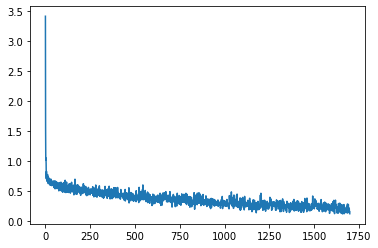

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.show()